<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ANN_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [24]:
!pip install -U scikit-learn

In [25]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [26]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [27]:
df0 = pd.read_csv("sp500sub.csv",index_col = 'Date',parse_dates = True)

In [28]:
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

In [29]:
df['LogClose'] = np.log(df['Close'])

In [30]:
df['DiffLogClose'] = df['LogClose'].diff()

In [31]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [32]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [33]:
#Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [34]:
df.loc[train_idx,'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx,'ScaledLogReturn'] = test_scaled.flatten()

In [35]:
#Make supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
print("X shape: ",X.shape,' Y Shape: ',Y.shape)

X shape:  (2252, 10)  Y Shape:  (2252,)


In [36]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [37]:
#Basic ANN
i = Input(shape=(T,))
x = Dense(32,activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)

In [38]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [39]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 200,
    validation_data = (XTest,YTest)
)

Epoch 1/200
70/70 [==============================] - 1s 4ms/step - loss: 1.1518 - val_loss: 1.5677
Epoch 2/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0501 - val_loss: 1.5563
Epoch 3/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0218 - val_loss: 1.5330
Epoch 4/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0071 - val_loss: 1.4829
Epoch 5/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9973 - val_loss: 1.4922
Epoch 6/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9887 - val_loss: 1.4887
Epoch 7/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9815 - val_loss: 1.4712
Epoch 8/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9759 - val_loss: 1.4617
Epoch 9/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9712 - val_loss: 1.4716
Epoch 10/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9690 - val_loss: 1.4602
Epoch 11/

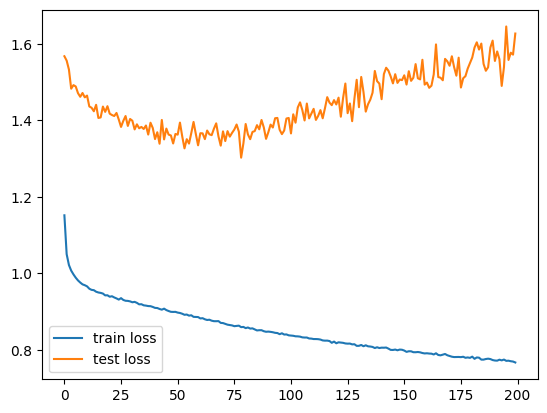

In [40]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();

In [41]:
#The first T+1 values are not predictable
train_idx[:T+1] = False

In [42]:
PTrain = model.predict(XTrain)
PTest = model.predict(XTest)

1/1 [==============================] - 0s 40ms/step


In [43]:
#Invert the scalling
PTrain = scaler.inverse_transform(PTrain).flatten()
PTest = scaler.inverse_transform(PTest).flatten()

In [44]:
#Store diff predictions
df.loc[train_idx,'Diff ANN Train Prediction'] = PTrain
df.loc[test_idx,'Diff ANN Test Prediction'] = PTest

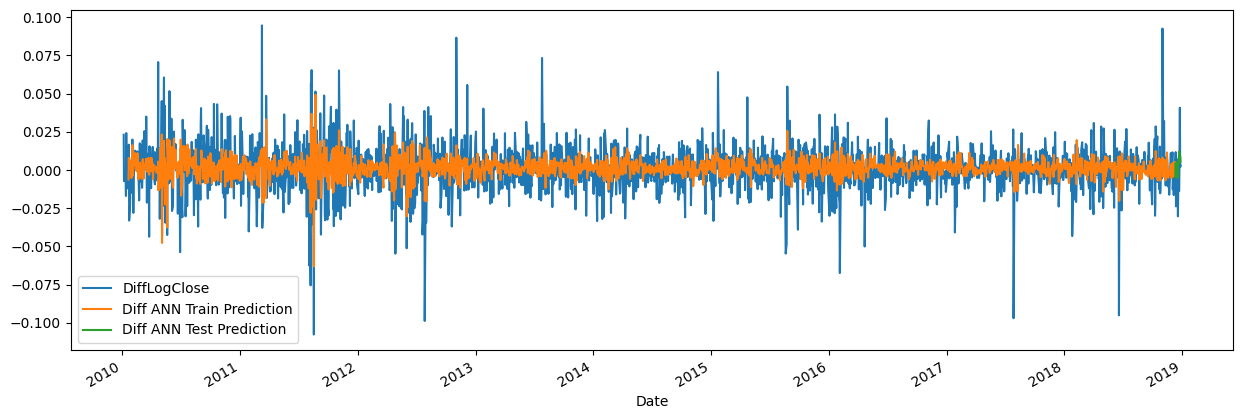

In [46]:
cols = [
    'DiffLogClose',
    'Diff ANN Train Prediction',
    'Diff ANN Test Prediction'
]
df[cols].plot(figsize = (15,5));

In [47]:
#Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [48]:
#Last-known train value
last_train = train.iloc[-1]['LogClose']

In [50]:
#1-step forecast
df.loc[train_idx,'1step_train'] = prev[train_idx] + PTrain
df.loc[test_idx,'1step_test'] = prev[test_idx] + PTest

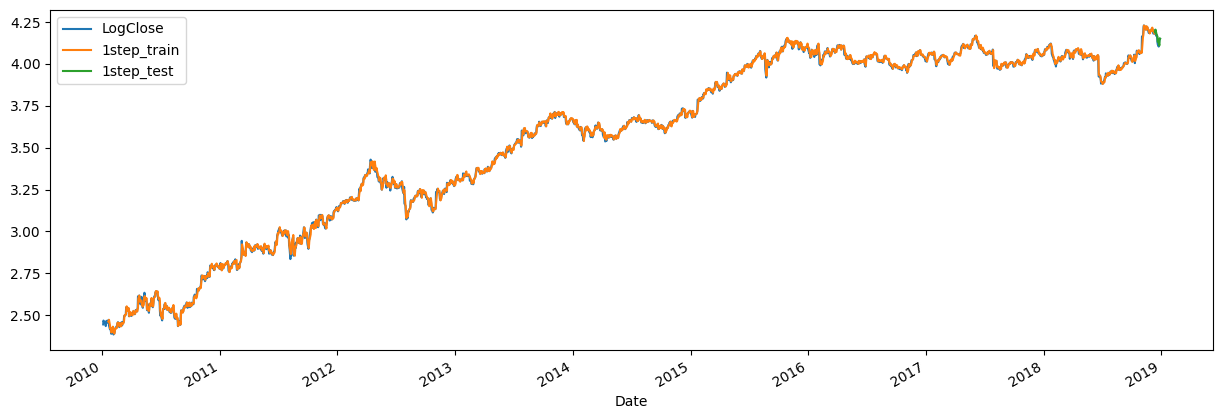

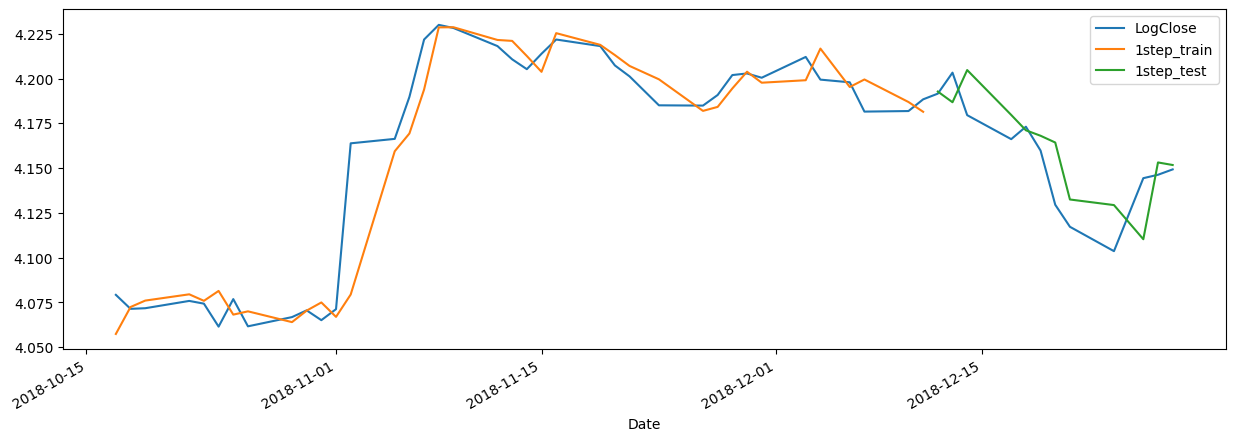

In [52]:
#Plot 1 step forecast
cols = [
    'LogClose',
    '1step_train',
    '1step_test'
]
df[cols].plot(figsize = (15,5))
df.iloc[-50:][cols].plot(figsize = (15,5));